In [1]:
import os
import numpy as np
import glob

import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.layers import Dropout, Input
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense

import tensorflow as tf

Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

In [3]:
train_x = np.load('/home/ckwwk/data/germination_data/train_germination.npy')
val_x = np.load('/home/ckwwk/data/germination_data/val_germination.npy')
test_x = np.load('/home/ckwwk/data/germination_data/test_germination.npy')

In [4]:
from PIL import Image
import numpy as np

In [5]:
a = train_x[1]
a.shape

(61, 61, 275, 1)

In [6]:
img2 = Image.fromarray(np.uint8(train_x[10][:,:,1,0] * 255) , 'L')

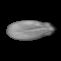

In [7]:
img2

In [8]:
train_x1 = train_x[0:500]
val_x1 = val_x[0:125]

In [9]:
train_x1.shape

(500, 61, 61, 275, 1)

In [10]:
import pandas as pd

label_df = pd.read_csv("/home/ckwwk/data/label/germination_label.csv")
label_df.head(5)

,0
0,0
1,0
2,1
3,0
4,0


In [11]:
from keras.utils import to_categorical
train_y = label_df[0:1000]
train_y = to_categorical(train_y)

In [12]:
train_y1 = label_df[0:500]
train_y1 = to_categorical(train_y1)

In [13]:
val_y = label_df[1000:1250]
val_y = to_categorical(val_y)
test_y = label_df[1250:1536]
test_y = to_categorical(test_y)

In [14]:
val_y1 = label_df[1000:1125]
val_y1 = to_categorical(val_y1)
test_y1 = label_df[1250:1536]
test_y1 = to_categorical(test_y1)

In [15]:
from keras.backend import tensorflow_backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [16]:
input_layer = Input((61, 61, 275, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu',padding='same')(input_layer)
conv_layer2 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu',padding='same')(conv_layer1)

## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu',padding='same')(pooling_layer1)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu',padding='same')(conv_layer3)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

conv_layer5 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu',padding='same')(pooling_layer2)
conv_layer6 = Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu',padding='same')(conv_layer5)
pooling_layer3 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer6)

conv_layer7 = Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu',padding='same')(pooling_layer3)
conv_layer8 = Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu',padding='same')(conv_layer7)
pooling_layer4 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer8)


## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer5 = BatchNormalization()(pooling_layer4)
flatten_layer = Flatten()(pooling_layer5)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=2, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 61, 61, 275, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 275, 16)   448       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 61, 61, 275, 32)   13856     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 137, 32)   0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 30, 30, 137, 32)   27680     
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 30, 30, 137, 64)   55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 15, 15, 68, 64)    0         
__________

In [18]:
from keras.utils import multi_gpu_model
model = multi_gpu_model(model,gpus=4)

In [20]:
adam = Adam(lr=0.005, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [21]:
filepath = "best-model_V5_1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
tb = keras.callbacks.TensorBoard(log_dir='/home/ckwwk/tensor_log_V5_1',histogram_freq=1,)
callbacks_list = [checkpoint,tb]

In [22]:
history = model.fit(x=train_x1, y=train_y1, batch_size=32, epochs=500, validation_data=(val_x1,val_y1),callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 500 samples, validate on 125 samples
Epoch 1/500
500/500 [==============================] - 33s 67ms/step - loss: 4.9501 - acc: 0.6560 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00001: acc improved from -inf to 0.65600, saving model to best-model_V5_1.hdf5
Epoch 2/500
500/500 [==============================] - 15s 30ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00002: acc improved from 0.65600 to 0.67800, saving model to best-model_V5_1.hdf5
Epoch 3/500
500/500 [==============================] - 15s 31ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00003: acc improved from 0.67800 to 0.67800, saving model to best-model_V5_1.hdf5
Epoch 4/500
500/500 [==============================] - 16s 31ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00004: acc did not improve from 0.67800
Epoch 5/500
500/500 [==============================] - 

Epoch 88/500
500/500 [==============================] - 15s 31ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00088: acc did not improve from 0.67800
Epoch 89/500
500/500 [==============================] - 16s 31ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00089: acc did not improve from 0.67800
Epoch 90/500
500/500 [==============================] - 16s 31ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00090: acc did not improve from 0.67800
Epoch 91/500
500/500 [==============================] - 16s 31ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00091: acc did not improve from 0.67800
Epoch 92/500
500/500 [==============================] - 15s 30ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00092: acc did not improve from 0.67800
Epoch 93/500
500/500 [==============================] - 16s 31ms/step - loss: 5.1900 


Epoch 00132: acc did not improve from 0.67800
Epoch 133/500
500/500 [==============================] - 16s 31ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00133: acc did not improve from 0.67800
Epoch 134/500
500/500 [==============================] - 15s 31ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00134: acc did not improve from 0.67800
Epoch 135/500
500/500 [==============================] - 16s 32ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00135: acc did not improve from 0.67800
Epoch 136/500
500/500 [==============================] - 15s 31ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00136: acc did not improve from 0.67800
Epoch 137/500
500/500 [==============================] - 16s 31ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00137: acc did not improve from 0.67800
Epoch 138/500
500/500 [==========


Epoch 00221: acc did not improve from 0.67800
Epoch 222/500
500/500 [==============================] - 16s 31ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00222: acc did not improve from 0.67800
Epoch 223/500
500/500 [==============================] - 16s 31ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00223: acc did not improve from 0.67800
Epoch 224/500
500/500 [==============================] - 16s 31ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00224: acc did not improve from 0.67800
Epoch 225/500
500/500 [==============================] - 15s 30ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00225: acc did not improve from 0.67800
Epoch 226/500
500/500 [==============================] - 16s 32ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00226: acc did not improve from 0.67800
Epoch 227/500
500/500 [==========


Epoch 00310: acc did not improve from 0.67800
Epoch 311/500
500/500 [==============================] - 16s 32ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00311: acc did not improve from 0.67800
Epoch 312/500
500/500 [==============================] - 15s 30ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00312: acc did not improve from 0.67800
Epoch 313/500
500/500 [==============================] - 15s 30ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00313: acc did not improve from 0.67800
Epoch 314/500
500/500 [==============================] - 15s 30ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00314: acc did not improve from 0.67800
Epoch 315/500
500/500 [==============================] - 15s 30ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00315: acc did not improve from 0.67800
Epoch 316/500
500/500 [==========


Epoch 00399: acc did not improve from 0.67800
Epoch 400/500
500/500 [==============================] - 16s 31ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00400: acc did not improve from 0.67800
Epoch 401/500
500/500 [==============================] - 15s 31ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00401: acc did not improve from 0.67800
Epoch 402/500
500/500 [==============================] - 15s 30ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00402: acc did not improve from 0.67800
Epoch 403/500
500/500 [==============================] - 15s 30ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00403: acc did not improve from 0.67800
Epoch 404/500
500/500 [==============================] - 15s 30ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00404: acc did not improve from 0.67800
Epoch 405/500
500/500 [==========


Epoch 00488: acc did not improve from 0.67800
Epoch 489/500
500/500 [==============================] - 15s 30ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00489: acc did not improve from 0.67800
Epoch 490/500
500/500 [==============================] - 15s 30ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00490: acc did not improve from 0.67800
Epoch 491/500
500/500 [==============================] - 15s 30ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00491: acc did not improve from 0.67800
Epoch 492/500
500/500 [==============================] - 16s 31ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00492: acc did not improve from 0.67800
Epoch 493/500
500/500 [==============================] - 15s 30ms/step - loss: 5.1900 - acc: 0.6780 - val_loss: 5.8025 - val_acc: 0.6400

Epoch 00493: acc did not improve from 0.67800
Epoch 494/500
500/500 [==========

In [23]:
# load best weights
model.load_weights("best-model_V5_1.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [24]:
#model.predict(test_x,batch_size=10)
model.evaluate(test_x,test_y,batch_size=32)

286/286 [==============================] - 6s 20ms/step


[5.8611257159626566, 0.63636363844771482]